In [1]:
import re
import math
import pandas as pd
import numpy as np
from collections import defaultdict

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours as ENN
from imblearn.under_sampling import RepeatedEditedNearestNeighbours as RENN
from imblearn.under_sampling import CondensedNearestNeighbour as CNN

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


from google.colab import drive
drive.mount("/content/drive")

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Mounted at /content/drive


Data was pulled from: https://codstats.net/leaderboards/
google drive link: https://drive.google.com/file/d/1-AKWwcvuOcNxV_YkhRTxQYLMHcCNBOg-/view?usp=sharing

## Cleaning 

Rename raw columns and clean out special characters

In [2]:
matches = pd.read_csv('/content/drive/MyDrive/capstone/data/match_stats.csv')
percent_cols = ['Headshots %',	'Accuracy_x',	'Winrate']
matches[percent_cols] = matches[percent_cols].apply(lambda x: pd.to_numeric(x.str.replace('%','')))
df = matches.rename(columns={'Headshots %': 'player_perc_headshots'
                  ,'Accuracy_x':'player_perc_accuracy'
                  ,'Accuracy_y': 'match_accuracy'
                  ,'Headshots': 'match_headshot_count'
                  ,'Time Played': 'match_time_played'
                  ,'Score Per Minute': 'match_score_per_minute'
                  ,'Shot': 'match_shot_count'
                  ,'Hit': 'match_hit_count'
                  ,'totalXp': 'match_total_XP'
                  ,'medal_Xp': 'match_medal_XP'
                  ,'LongestStreak': 'match_longest_streak'
                  ,'cod_level': 'level'
                  ,'Winrate': 'player_perc_wins'
                  })
df.columns = df.columns.str.replace(' ', '_').str.lower()

df['avg_lifetime'] = pd.to_numeric(df['avg_lifetime'].str.replace('sec', ''))
df = df[(df['level'] <= 155) & (df['level'] >=15)].drop(columns='unnamed:_0')
df.head()

,rank,profile_href,gaming_system,handle,level,kda_ratio,avg_lifetime,score_per_game,player_perc_headshots,player_perc_accuracy,player_perc_wins,match_date,score,match_accuracy,match_time_played,match_headshot_count,match_score_per_minute,match_shot_count,match_hit_count,match_total_xp,medalxp,match_longest_streak
0,1,/profile/pc/Dudebro%2311878,pc,Dudebro%2311878,55,3.82,181.0,3062.0,40.0,26.0,68.3,5 Aug15:43,1225.0,22.0,9.0,4.0,144.0,158.0,34.0,7737.0,4925.0,5.0
1,1,/profile/pc/Dudebro%2311878,pc,Dudebro%2311878,55,3.82,181.0,3062.0,40.0,26.0,68.3,31 Jul19:25,1350.0,45.0,8.0,4.0,176.0,29.0,13.0,16018.0,4700.0,12.0
2,1,/profile/pc/Dudebro%2311878,pc,Dudebro%2311878,55,3.82,181.0,3062.0,40.0,26.0,68.3,31 Jul19:15,1325.0,75.0,8.0,2.0,169.0,16.0,12.0,16618.0,4900.0,12.0
3,1,/profile/pc/Dudebro%2311878,pc,Dudebro%2311878,55,3.82,181.0,3062.0,40.0,26.0,68.3,31 Jul19:05,2630.0,25.0,9.0,1.0,308.0,103.0,26.0,27778.0,8720.0,22.0
4,1,/profile/pc/Dudebro%2311878,pc,Dudebro%2311878,55,3.82,181.0,3062.0,40.0,26.0,68.3,31 Jul18:53,1525.0,59.0,10.0,5.0,159.0,22.0,13.0,19390.0,5460.0,7.0


Class imbalances:


*   Levels 55 and 155 are over represented
*   Levels under 55 are under represented



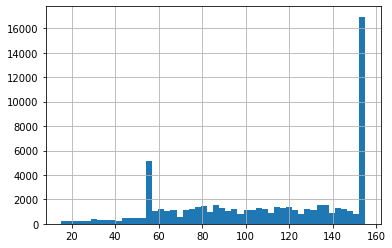

In [3]:
df['level'].hist(bins=50);


## Reclassifying the players that have all around extremely high stats

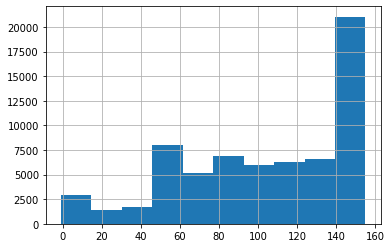

In [4]:
def label_outliers(df, cols):
  '''
  For each level, the mean is calculated for a column.
  If players score above three standard deviations above the mean then their name is added to the dictionary with the column appended
  If players are an outlier for three or more columns, their handle is returned
  '''
  suspect = defaultdict(list)
  for level in df['level'].unique():
    players = df[df['level'] == level]
    for col in cols:
      boundary = (3.5*players[col].std()) + players[col].mean()
      above_bound_players = list(players[players[col]>boundary].handle.unique())
      for sus in above_bound_players:
        suspect[sus].append(col)
  
  all_around_sus = [player for player, cols in suspect.items() if len(cols) > 3]
  return all_around_sus

cols = 'kda_ratio	avg_lifetime	score_per_game	player_perc_headshots	player_perc_accuracy	player_perc_wins	score	match_accuracy	match_time_played	match_headshot_count	match_score_per_minute	match_shot_count	match_hit_count	match_total_xp	medalxp	match_longest_streak'.split("\t")

sus_players = label_outliers(df, cols)
# Relabel the outlier players in a new df. Their flag value will be -1
relabeled = df.copy()
relabeled.loc[relabeled.handle.isin(sus_players), 'level'] = -1
relabeled['level'] = pd.to_numeric(relabeled.level)
relabeled.level.hist()

After relabeling, the class imbalances aren't as extreme. Definitely need to collect more data.

## To *slightly* dampen the effects of class imbalances, over and under sampling will be applied

In [6]:
def arr_to_df(df, X_arr, y_arr):
  '''
  df: dataframe to extract column names from
  X_arr: nested array,  to be reformated into dataframe. 
  Y_arr: 1-d array, to be reformated into a Series
  '''
  try:
    columns = df.select_dtypes(exclude='object').drop(columns=[ 'level']).columns
  except:
    columns = df.select_dtypes(exclude='object').columns
  X = pd.DataFrame(X_arr, columns=columns)
  y = pd.Series(y_arr)
  return X,y

Trying out imblearn's smote & edited nearest neighbor combo function

AxesSubplot(0.125,0.125;0.775x0.755)


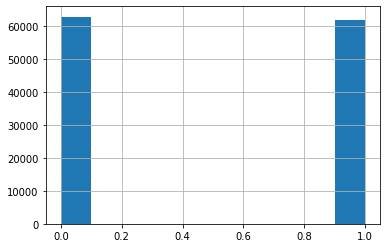

In [7]:
_relabeled = relabeled.dropna()
X = _relabeled.select_dtypes(exclude='object').drop(columns=['level'])
y = _relabeled['level']
binary_y = y.copy()
binary_y.loc[binary_y>0] = 0
binary_y.loc[binary_y<0] = 1


smoteenn= SMOTEENN(enn=ENN(n_neighbors=3), smote=SMOTE(k_neighbors=3))
X_smoteenn, y_smoteenn=smoteenn.fit_resample(X,binary_y)
X_smoteenn_df, y_smoteenn_df = arr_to_df(relabeled, X_smoteenn, y_smoteenn)
print(y_smoteenn_df.hist())

ENN down sampled the two majority classes and smote upsampled everything but the flagged values

In [8]:
def over_under_sample(df, under_sample_funcs):
  _df = df.dropna()
  X = _df.select_dtypes(exclude='object').drop(columns=['level'])
  y = _df['level']
  binary_y = y.copy()
  binary_y.loc[binary_y>0] = 0
  binary_y.loc[binary_y<0] = 1

  res = {}
  for (under_tag, under_func) in under_sample_funcs:
    try:
      under_samp_X, under_samp_y = under_func.fit_resample(X,y)
      smote = SMOTE(k_neighbors=1)
      over_samp_X, over_samp_y = smote.fit_resample(under_samp_X, under_samp_y)
      res[under_tag] = arr_to_df(_df, over_samp_X,over_samp_y)
    except ValueError:
      pass
  
  return res

renn = RENN(sampling_strategy=[55,155],n_neighbors=3)
enn = ENN(n_neighbors=3)
cnn = CNN(sampling_strategy=[55,155])
under_sample_funcs = [('renn', renn), ('enn', enn), ('cnn', cnn)]

res = over_under_sample(relabeled, under_sample_funcs)

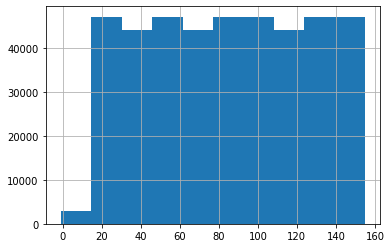

In [9]:
res['renn'][1].hist()

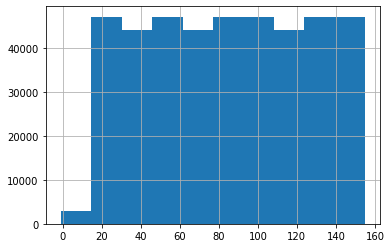

In [10]:
res['cnn'][1].hist()

SMOTE is probably having a hard up sampling the outliers because their values are so extreme. I'll be pulling from the top of the leaderboards to find some more data to flag this weekend. I can bootstrap and random sample the flagged values.

I was originally avoiding the cheaters because I thought that would interfere with smurf detection. I recently found out that COD has hacks, not smurfs.

Only. Model. Games. You. Play.

## Scaling and train-test split

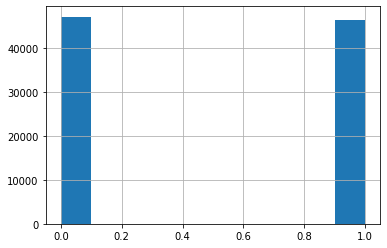

In [11]:
X,y = X_smoteenn_df.copy(), y_smoteenn_df.copy() # Picking a resampled df with a lower number of samples per class until I pull more data

X_train, X_test, y_train, y_test = train_test_split(X,y)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

X_train_df, y_train_series = arr_to_df(X, X_train_sc, y_train)
X_test_df, y_test_series = arr_to_df(X, X_test_sc, y_test)
y_train_series.hist()

In [12]:
X_train_df.to_csv('/content/drive/MyDrive/capstone/data/X_train.csv')
y_train_series.to_csv('/content/drive/MyDrive/capstone/data/y_train.csv')

X_test_df.to_csv('/content/drive/MyDrive/capstone/data/X_test.csv')
y_test_series.to_csv('/content/drive/MyDrive/capstone/data/y_test.csv')

# Use a df that still has level labels for EDA aka Non-binarized y
eda_df = res['renn'][0].copy()
eda_df['level'] = res['renn'][1]
eda_df.to_csv('/content/drive/MyDrive/capstone/data/eda_df.csv')